# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

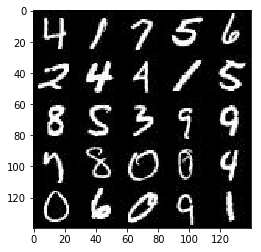

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

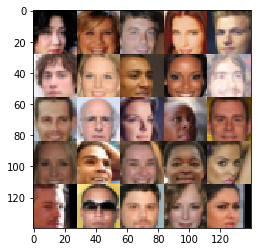

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(g_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


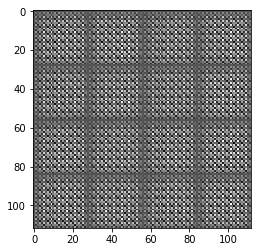

Epoch 1/2... Generator Loss: 11.3144 Discriminator Loss: 0.4766...
Epoch 1/2... Generator Loss: 0.7171 Discriminator Loss: 1.5761...
Epoch 1/2... Generator Loss: 3.8434 Discriminator Loss: 0.5682...
Epoch 1/2... Generator Loss: 4.3041 Discriminator Loss: 0.3926...
Epoch 1/2... Generator Loss: 1.4962 Discriminator Loss: 0.7935...
Epoch 1/2... Generator Loss: 4.1695 Discriminator Loss: 0.3890...
Epoch 1/2... Generator Loss: 0.5043 Discriminator Loss: 1.4480...
Epoch 1/2... Generator Loss: 0.9487 Discriminator Loss: 1.1225...
Epoch 1/2... Generator Loss: 2.3048 Discriminator Loss: 1.2109...
Epoch 1/2... Generator Loss: 1.3134 Discriminator Loss: 1.0563...


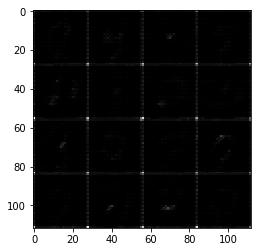

Epoch 1/2... Generator Loss: 0.8752 Discriminator Loss: 1.2136...
Epoch 1/2... Generator Loss: 1.6781 Discriminator Loss: 0.9580...
Epoch 1/2... Generator Loss: 1.1729 Discriminator Loss: 0.9999...
Epoch 1/2... Generator Loss: 1.1992 Discriminator Loss: 0.9680...
Epoch 1/2... Generator Loss: 2.4542 Discriminator Loss: 1.0976...
Epoch 1/2... Generator Loss: 0.9686 Discriminator Loss: 1.1407...
Epoch 1/2... Generator Loss: 0.6712 Discriminator Loss: 1.2892...
Epoch 1/2... Generator Loss: 1.4255 Discriminator Loss: 1.2660...
Epoch 1/2... Generator Loss: 0.6066 Discriminator Loss: 1.4394...
Epoch 1/2... Generator Loss: 1.5420 Discriminator Loss: 1.0787...


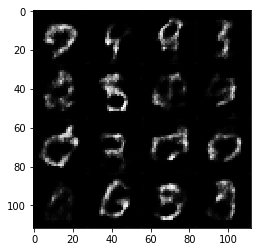

Epoch 1/2... Generator Loss: 0.7591 Discriminator Loss: 1.2465...
Epoch 1/2... Generator Loss: 0.8237 Discriminator Loss: 1.1602...
Epoch 1/2... Generator Loss: 0.9400 Discriminator Loss: 1.1974...
Epoch 1/2... Generator Loss: 0.7435 Discriminator Loss: 1.3238...
Epoch 1/2... Generator Loss: 1.1024 Discriminator Loss: 1.1077...
Epoch 1/2... Generator Loss: 1.4926 Discriminator Loss: 1.2703...
Epoch 1/2... Generator Loss: 0.8654 Discriminator Loss: 1.1797...
Epoch 1/2... Generator Loss: 0.9903 Discriminator Loss: 1.2076...
Epoch 1/2... Generator Loss: 0.7833 Discriminator Loss: 1.3224...
Epoch 1/2... Generator Loss: 1.3126 Discriminator Loss: 1.1836...


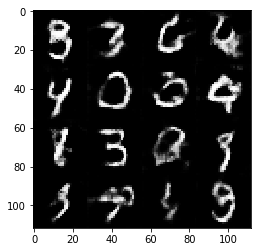

Epoch 1/2... Generator Loss: 1.3816 Discriminator Loss: 1.1772...
Epoch 1/2... Generator Loss: 1.0265 Discriminator Loss: 1.2126...
Epoch 1/2... Generator Loss: 0.4290 Discriminator Loss: 1.7230...
Epoch 1/2... Generator Loss: 1.1930 Discriminator Loss: 1.0774...
Epoch 1/2... Generator Loss: 0.7107 Discriminator Loss: 1.2790...
Epoch 1/2... Generator Loss: 0.9985 Discriminator Loss: 1.1262...
Epoch 1/2... Generator Loss: 0.6901 Discriminator Loss: 1.2696...
Epoch 1/2... Generator Loss: 0.8427 Discriminator Loss: 1.2432...
Epoch 1/2... Generator Loss: 0.6884 Discriminator Loss: 1.2396...
Epoch 1/2... Generator Loss: 0.5770 Discriminator Loss: 1.3536...


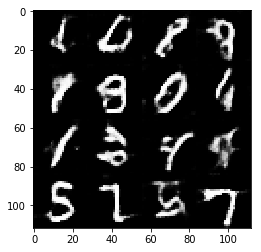

Epoch 1/2... Generator Loss: 1.2669 Discriminator Loss: 1.1240...
Epoch 1/2... Generator Loss: 1.7204 Discriminator Loss: 1.2359...
Epoch 1/2... Generator Loss: 0.9683 Discriminator Loss: 1.1507...
Epoch 1/2... Generator Loss: 2.0577 Discriminator Loss: 1.3973...
Epoch 1/2... Generator Loss: 1.1412 Discriminator Loss: 1.0798...
Epoch 1/2... Generator Loss: 2.1267 Discriminator Loss: 1.5823...
Epoch 2/2... Generator Loss: 0.8542 Discriminator Loss: 1.2100...
Epoch 2/2... Generator Loss: 1.2254 Discriminator Loss: 1.0805...
Epoch 2/2... Generator Loss: 0.7515 Discriminator Loss: 1.2117...
Epoch 2/2... Generator Loss: 2.0518 Discriminator Loss: 1.3215...


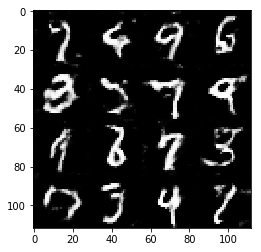

Epoch 2/2... Generator Loss: 1.0497 Discriminator Loss: 1.1250...
Epoch 2/2... Generator Loss: 0.6326 Discriminator Loss: 1.3153...
Epoch 2/2... Generator Loss: 1.7581 Discriminator Loss: 1.1767...
Epoch 2/2... Generator Loss: 0.7246 Discriminator Loss: 1.2436...
Epoch 2/2... Generator Loss: 0.9482 Discriminator Loss: 1.2021...
Epoch 2/2... Generator Loss: 1.6588 Discriminator Loss: 1.3148...
Epoch 2/2... Generator Loss: 0.8766 Discriminator Loss: 1.1815...
Epoch 2/2... Generator Loss: 1.0182 Discriminator Loss: 1.0931...
Epoch 2/2... Generator Loss: 1.1407 Discriminator Loss: 1.0781...
Epoch 2/2... Generator Loss: 1.7030 Discriminator Loss: 1.2799...


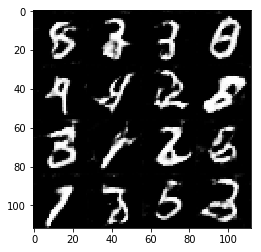

Epoch 2/2... Generator Loss: 1.0468 Discriminator Loss: 1.1890...
Epoch 2/2... Generator Loss: 0.9915 Discriminator Loss: 1.0894...
Epoch 2/2... Generator Loss: 1.1838 Discriminator Loss: 1.2100...
Epoch 2/2... Generator Loss: 1.0781 Discriminator Loss: 1.0766...
Epoch 2/2... Generator Loss: 1.4677 Discriminator Loss: 1.2166...
Epoch 2/2... Generator Loss: 0.7871 Discriminator Loss: 1.2272...
Epoch 2/2... Generator Loss: 1.5925 Discriminator Loss: 1.0730...
Epoch 2/2... Generator Loss: 1.1069 Discriminator Loss: 1.1048...
Epoch 2/2... Generator Loss: 0.9848 Discriminator Loss: 1.0374...
Epoch 2/2... Generator Loss: 1.1479 Discriminator Loss: 1.0800...


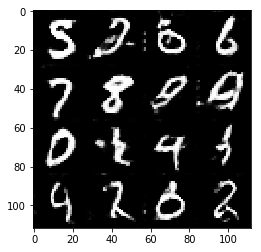

Epoch 2/2... Generator Loss: 0.9513 Discriminator Loss: 1.1918...
Epoch 2/2... Generator Loss: 0.9169 Discriminator Loss: 1.2335...
Epoch 2/2... Generator Loss: 0.9966 Discriminator Loss: 1.2178...
Epoch 2/2... Generator Loss: 1.5520 Discriminator Loss: 1.1287...
Epoch 2/2... Generator Loss: 1.0171 Discriminator Loss: 1.1192...
Epoch 2/2... Generator Loss: 0.8482 Discriminator Loss: 1.2298...
Epoch 2/2... Generator Loss: 1.2128 Discriminator Loss: 1.1966...
Epoch 2/2... Generator Loss: 0.8649 Discriminator Loss: 1.1311...
Epoch 2/2... Generator Loss: 0.8397 Discriminator Loss: 1.1557...
Epoch 2/2... Generator Loss: 1.3414 Discriminator Loss: 1.0374...


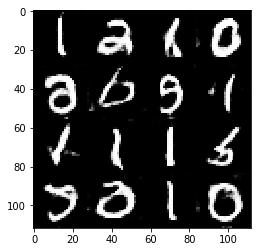

Epoch 2/2... Generator Loss: 1.9977 Discriminator Loss: 1.3213...
Epoch 2/2... Generator Loss: 1.6070 Discriminator Loss: 1.1453...
Epoch 2/2... Generator Loss: 0.5500 Discriminator Loss: 1.3453...
Epoch 2/2... Generator Loss: 1.5467 Discriminator Loss: 1.2879...
Epoch 2/2... Generator Loss: 0.6795 Discriminator Loss: 1.2988...
Epoch 2/2... Generator Loss: 1.5480 Discriminator Loss: 1.1850...
Epoch 2/2... Generator Loss: 0.6940 Discriminator Loss: 1.3332...
Epoch 2/2... Generator Loss: 0.6996 Discriminator Loss: 1.2732...
Epoch 2/2... Generator Loss: 0.8648 Discriminator Loss: 1.2239...
Epoch 2/2... Generator Loss: 1.1346 Discriminator Loss: 1.0396...


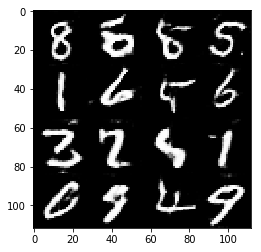

Epoch 2/2... Generator Loss: 1.2750 Discriminator Loss: 1.1052...
Epoch 2/2... Generator Loss: 0.9383 Discriminator Loss: 1.2325...
Epoch 2/2... Generator Loss: 0.8000 Discriminator Loss: 1.2081...


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


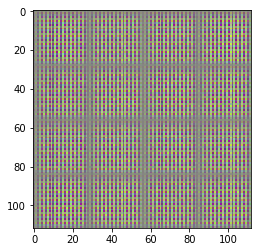

Epoch 1/1... Generator Loss: 1.0723 Discriminator Loss: 1.2791...
Epoch 1/1... Generator Loss: 4.3019 Discriminator Loss: 0.4768...
Epoch 1/1... Generator Loss: 3.7264 Discriminator Loss: 0.4833...
Epoch 1/1... Generator Loss: 3.0256 Discriminator Loss: 0.7629...
Epoch 1/1... Generator Loss: 0.7291 Discriminator Loss: 1.3668...
Epoch 1/1... Generator Loss: 1.9161 Discriminator Loss: 0.7574...
Epoch 1/1... Generator Loss: 2.6843 Discriminator Loss: 0.6511...
Epoch 1/1... Generator Loss: 0.2159 Discriminator Loss: 2.6017...
Epoch 1/1... Generator Loss: 1.0615 Discriminator Loss: 0.9269...
Epoch 1/1... Generator Loss: 0.7663 Discriminator Loss: 1.3222...


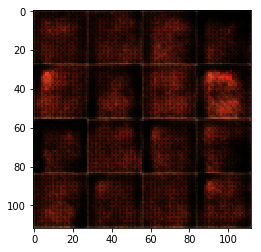

Epoch 1/1... Generator Loss: 0.3895 Discriminator Loss: 1.8064...
Epoch 1/1... Generator Loss: 1.0819 Discriminator Loss: 1.2425...
Epoch 1/1... Generator Loss: 0.8827 Discriminator Loss: 1.2763...
Epoch 1/1... Generator Loss: 1.2244 Discriminator Loss: 1.0946...
Epoch 1/1... Generator Loss: 1.4314 Discriminator Loss: 1.2494...
Epoch 1/1... Generator Loss: 0.7721 Discriminator Loss: 1.2138...
Epoch 1/1... Generator Loss: 0.8576 Discriminator Loss: 1.3200...
Epoch 1/1... Generator Loss: 1.5927 Discriminator Loss: 1.1960...
Epoch 1/1... Generator Loss: 0.8425 Discriminator Loss: 1.2296...
Epoch 1/1... Generator Loss: 0.5521 Discriminator Loss: 1.3310...


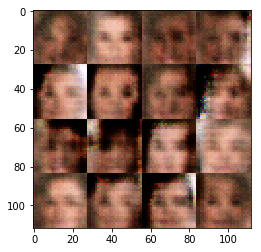

Epoch 1/1... Generator Loss: 1.5239 Discriminator Loss: 1.3489...
Epoch 1/1... Generator Loss: 1.0109 Discriminator Loss: 1.3561...
Epoch 1/1... Generator Loss: 0.8929 Discriminator Loss: 1.1841...
Epoch 1/1... Generator Loss: 2.4990 Discriminator Loss: 2.3676...
Epoch 1/1... Generator Loss: 0.8434 Discriminator Loss: 1.1296...
Epoch 1/1... Generator Loss: 1.9518 Discriminator Loss: 1.9656...
Epoch 1/1... Generator Loss: 0.8123 Discriminator Loss: 1.3649...
Epoch 1/1... Generator Loss: 0.8276 Discriminator Loss: 1.1896...
Epoch 1/1... Generator Loss: 0.8672 Discriminator Loss: 1.1159...
Epoch 1/1... Generator Loss: 0.7679 Discriminator Loss: 1.3151...


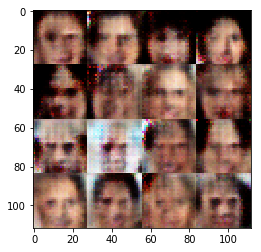

Epoch 1/1... Generator Loss: 1.1268 Discriminator Loss: 1.4329...
Epoch 1/1... Generator Loss: 1.2321 Discriminator Loss: 1.2670...
Epoch 1/1... Generator Loss: 0.2939 Discriminator Loss: 1.8001...
Epoch 1/1... Generator Loss: 1.0058 Discriminator Loss: 1.1210...
Epoch 1/1... Generator Loss: 1.5927 Discriminator Loss: 1.4437...
Epoch 1/1... Generator Loss: 0.5498 Discriminator Loss: 1.3951...
Epoch 1/1... Generator Loss: 0.3794 Discriminator Loss: 1.6942...
Epoch 1/1... Generator Loss: 0.4889 Discriminator Loss: 1.5134...
Epoch 1/1... Generator Loss: 1.0800 Discriminator Loss: 1.1341...
Epoch 1/1... Generator Loss: 0.9418 Discriminator Loss: 1.2947...


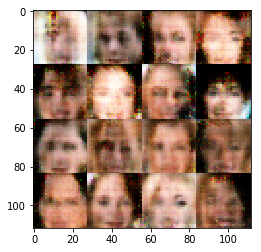

Epoch 1/1... Generator Loss: 0.7588 Discriminator Loss: 1.3457...
Epoch 1/1... Generator Loss: 0.9054 Discriminator Loss: 1.0996...
Epoch 1/1... Generator Loss: 0.6200 Discriminator Loss: 1.3647...
Epoch 1/1... Generator Loss: 2.1317 Discriminator Loss: 1.7607...
Epoch 1/1... Generator Loss: 0.7486 Discriminator Loss: 1.3116...
Epoch 1/1... Generator Loss: 0.7168 Discriminator Loss: 1.2990...
Epoch 1/1... Generator Loss: 0.5457 Discriminator Loss: 1.4205...
Epoch 1/1... Generator Loss: 1.7530 Discriminator Loss: 1.2953...
Epoch 1/1... Generator Loss: 1.0607 Discriminator Loss: 1.2668...
Epoch 1/1... Generator Loss: 0.8047 Discriminator Loss: 1.3937...


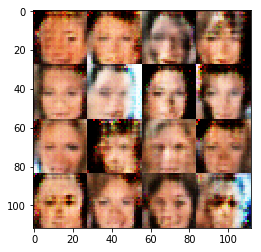

Epoch 1/1... Generator Loss: 0.5948 Discriminator Loss: 1.3195...
Epoch 1/1... Generator Loss: 0.7234 Discriminator Loss: 1.2027...
Epoch 1/1... Generator Loss: 0.7694 Discriminator Loss: 1.2222...
Epoch 1/1... Generator Loss: 0.5136 Discriminator Loss: 1.4620...
Epoch 1/1... Generator Loss: 0.9431 Discriminator Loss: 1.0861...
Epoch 1/1... Generator Loss: 0.8707 Discriminator Loss: 1.2208...
Epoch 1/1... Generator Loss: 0.6848 Discriminator Loss: 1.3859...
Epoch 1/1... Generator Loss: 0.7369 Discriminator Loss: 1.3513...
Epoch 1/1... Generator Loss: 0.9827 Discriminator Loss: 1.2938...
Epoch 1/1... Generator Loss: 0.7757 Discriminator Loss: 1.3242...


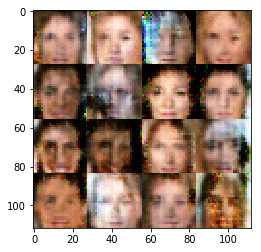

Epoch 1/1... Generator Loss: 0.5665 Discriminator Loss: 1.3739...
Epoch 1/1... Generator Loss: 0.6228 Discriminator Loss: 1.4667...
Epoch 1/1... Generator Loss: 0.9305 Discriminator Loss: 1.2237...
Epoch 1/1... Generator Loss: 1.0749 Discriminator Loss: 1.3246...
Epoch 1/1... Generator Loss: 1.0410 Discriminator Loss: 1.4255...
Epoch 1/1... Generator Loss: 1.4811 Discriminator Loss: 1.3991...
Epoch 1/1... Generator Loss: 0.7597 Discriminator Loss: 1.3144...
Epoch 1/1... Generator Loss: 0.8796 Discriminator Loss: 1.2065...
Epoch 1/1... Generator Loss: 1.0617 Discriminator Loss: 1.3031...
Epoch 1/1... Generator Loss: 1.2931 Discriminator Loss: 1.4039...


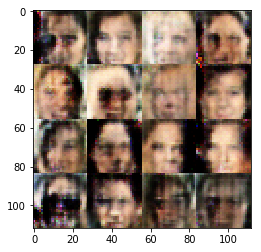

Epoch 1/1... Generator Loss: 1.1808 Discriminator Loss: 1.2740...
Epoch 1/1... Generator Loss: 0.9831 Discriminator Loss: 1.2741...
Epoch 1/1... Generator Loss: 1.0390 Discriminator Loss: 1.3456...
Epoch 1/1... Generator Loss: 0.5990 Discriminator Loss: 1.4418...
Epoch 1/1... Generator Loss: 0.5683 Discriminator Loss: 1.4188...
Epoch 1/1... Generator Loss: 0.7605 Discriminator Loss: 1.3225...
Epoch 1/1... Generator Loss: 0.7312 Discriminator Loss: 1.2651...
Epoch 1/1... Generator Loss: 0.6078 Discriminator Loss: 1.4178...
Epoch 1/1... Generator Loss: 0.9886 Discriminator Loss: 1.2820...
Epoch 1/1... Generator Loss: 0.8001 Discriminator Loss: 1.4316...


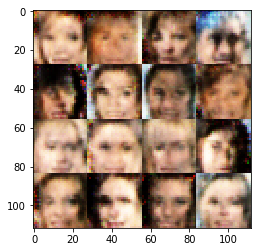

Epoch 1/1... Generator Loss: 0.6308 Discriminator Loss: 1.3676...
Epoch 1/1... Generator Loss: 0.5926 Discriminator Loss: 1.3622...
Epoch 1/1... Generator Loss: 0.5754 Discriminator Loss: 1.3945...
Epoch 1/1... Generator Loss: 0.6278 Discriminator Loss: 1.4044...
Epoch 1/1... Generator Loss: 0.5819 Discriminator Loss: 1.3996...
Epoch 1/1... Generator Loss: 0.8218 Discriminator Loss: 1.2207...
Epoch 1/1... Generator Loss: 1.0530 Discriminator Loss: 1.3674...
Epoch 1/1... Generator Loss: 0.6933 Discriminator Loss: 1.4116...
Epoch 1/1... Generator Loss: 0.9309 Discriminator Loss: 1.3035...
Epoch 1/1... Generator Loss: 1.0875 Discriminator Loss: 1.2547...


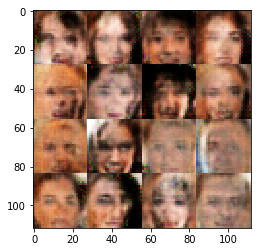

Epoch 1/1... Generator Loss: 0.6503 Discriminator Loss: 1.3569...
Epoch 1/1... Generator Loss: 0.6870 Discriminator Loss: 1.4090...
Epoch 1/1... Generator Loss: 0.9856 Discriminator Loss: 1.3579...
Epoch 1/1... Generator Loss: 0.7350 Discriminator Loss: 1.2704...
Epoch 1/1... Generator Loss: 1.5614 Discriminator Loss: 1.8584...
Epoch 1/1... Generator Loss: 0.5049 Discriminator Loss: 1.5694...
Epoch 1/1... Generator Loss: 0.7852 Discriminator Loss: 1.3512...
Epoch 1/1... Generator Loss: 0.7447 Discriminator Loss: 1.3286...
Epoch 1/1... Generator Loss: 0.7799 Discriminator Loss: 1.4349...
Epoch 1/1... Generator Loss: 0.6454 Discriminator Loss: 1.4566...


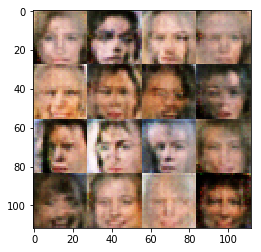

Epoch 1/1... Generator Loss: 0.7063 Discriminator Loss: 1.3561...
Epoch 1/1... Generator Loss: 0.7082 Discriminator Loss: 1.3749...
Epoch 1/1... Generator Loss: 1.0046 Discriminator Loss: 1.3833...
Epoch 1/1... Generator Loss: 0.8627 Discriminator Loss: 1.3772...
Epoch 1/1... Generator Loss: 0.6894 Discriminator Loss: 1.3484...
Epoch 1/1... Generator Loss: 0.9706 Discriminator Loss: 1.3389...
Epoch 1/1... Generator Loss: 0.4634 Discriminator Loss: 1.5471...
Epoch 1/1... Generator Loss: 0.6452 Discriminator Loss: 1.3746...
Epoch 1/1... Generator Loss: 0.9101 Discriminator Loss: 1.3795...
Epoch 1/1... Generator Loss: 1.1417 Discriminator Loss: 1.3798...


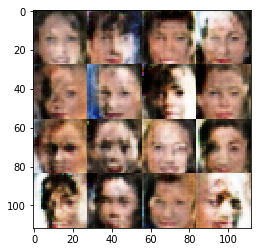

Epoch 1/1... Generator Loss: 0.7922 Discriminator Loss: 1.4432...
Epoch 1/1... Generator Loss: 0.7486 Discriminator Loss: 1.3369...
Epoch 1/1... Generator Loss: 0.7706 Discriminator Loss: 1.3080...
Epoch 1/1... Generator Loss: 0.8164 Discriminator Loss: 1.3185...
Epoch 1/1... Generator Loss: 0.9075 Discriminator Loss: 1.3277...
Epoch 1/1... Generator Loss: 0.5496 Discriminator Loss: 1.4728...
Epoch 1/1... Generator Loss: 0.7495 Discriminator Loss: 1.3779...
Epoch 1/1... Generator Loss: 0.5870 Discriminator Loss: 1.3425...
Epoch 1/1... Generator Loss: 0.7104 Discriminator Loss: 1.3378...
Epoch 1/1... Generator Loss: 0.6568 Discriminator Loss: 1.3834...


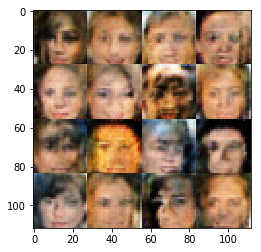

Epoch 1/1... Generator Loss: 0.8684 Discriminator Loss: 1.3956...
Epoch 1/1... Generator Loss: 0.7122 Discriminator Loss: 1.3150...
Epoch 1/1... Generator Loss: 0.8774 Discriminator Loss: 1.3679...
Epoch 1/1... Generator Loss: 0.8831 Discriminator Loss: 1.2822...
Epoch 1/1... Generator Loss: 0.8517 Discriminator Loss: 1.4041...
Epoch 1/1... Generator Loss: 0.7345 Discriminator Loss: 1.4145...
Epoch 1/1... Generator Loss: 1.1166 Discriminator Loss: 1.2477...
Epoch 1/1... Generator Loss: 0.8216 Discriminator Loss: 1.4238...
Epoch 1/1... Generator Loss: 0.8075 Discriminator Loss: 1.3830...
Epoch 1/1... Generator Loss: 0.8945 Discriminator Loss: 1.3945...


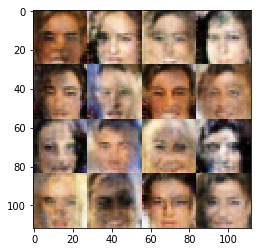

Epoch 1/1... Generator Loss: 1.1595 Discriminator Loss: 1.3637...
Epoch 1/1... Generator Loss: 0.8384 Discriminator Loss: 1.2659...
Epoch 1/1... Generator Loss: 0.8646 Discriminator Loss: 1.3558...
Epoch 1/1... Generator Loss: 0.9137 Discriminator Loss: 1.3871...
Epoch 1/1... Generator Loss: 0.7352 Discriminator Loss: 1.4252...
Epoch 1/1... Generator Loss: 0.7682 Discriminator Loss: 1.4458...
Epoch 1/1... Generator Loss: 0.9127 Discriminator Loss: 1.3761...
Epoch 1/1... Generator Loss: 0.7162 Discriminator Loss: 1.3573...
Epoch 1/1... Generator Loss: 0.7600 Discriminator Loss: 1.2545...
Epoch 1/1... Generator Loss: 0.9433 Discriminator Loss: 1.3794...


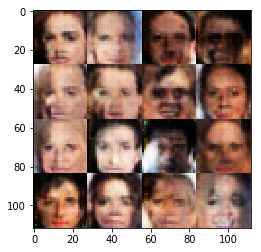

Epoch 1/1... Generator Loss: 1.0346 Discriminator Loss: 1.3784...
Epoch 1/1... Generator Loss: 0.9910 Discriminator Loss: 1.4700...
Epoch 1/1... Generator Loss: 0.9738 Discriminator Loss: 1.3859...
Epoch 1/1... Generator Loss: 0.5256 Discriminator Loss: 1.4738...
Epoch 1/1... Generator Loss: 0.8575 Discriminator Loss: 1.3365...
Epoch 1/1... Generator Loss: 0.8349 Discriminator Loss: 1.4061...
Epoch 1/1... Generator Loss: 0.6510 Discriminator Loss: 1.3671...
Epoch 1/1... Generator Loss: 1.1220 Discriminator Loss: 1.4812...
Epoch 1/1... Generator Loss: 1.0899 Discriminator Loss: 1.3771...
Epoch 1/1... Generator Loss: 0.7781 Discriminator Loss: 1.4116...


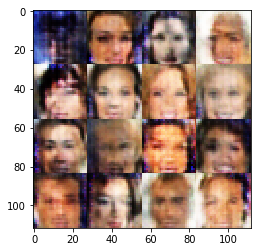

Epoch 1/1... Generator Loss: 0.9343 Discriminator Loss: 1.4006...
Epoch 1/1... Generator Loss: 0.7984 Discriminator Loss: 1.3175...
Epoch 1/1... Generator Loss: 1.0342 Discriminator Loss: 1.3918...
Epoch 1/1... Generator Loss: 0.5846 Discriminator Loss: 1.4013...
Epoch 1/1... Generator Loss: 0.9719 Discriminator Loss: 1.4356...
Epoch 1/1... Generator Loss: 0.6672 Discriminator Loss: 1.2928...
Epoch 1/1... Generator Loss: 0.6899 Discriminator Loss: 1.2741...
Epoch 1/1... Generator Loss: 0.6089 Discriminator Loss: 1.3300...
Epoch 1/1... Generator Loss: 0.9114 Discriminator Loss: 1.3664...
Epoch 1/1... Generator Loss: 0.8108 Discriminator Loss: 1.2631...


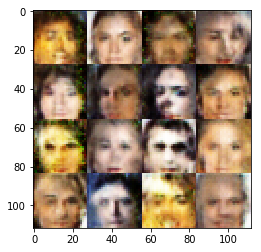

Epoch 1/1... Generator Loss: 0.9422 Discriminator Loss: 1.4386...
Epoch 1/1... Generator Loss: 0.7305 Discriminator Loss: 1.3179...
Epoch 1/1... Generator Loss: 0.8926 Discriminator Loss: 1.3197...
Epoch 1/1... Generator Loss: 0.9633 Discriminator Loss: 1.3761...
Epoch 1/1... Generator Loss: 0.7828 Discriminator Loss: 1.2838...
Epoch 1/1... Generator Loss: 0.8333 Discriminator Loss: 1.3290...
Epoch 1/1... Generator Loss: 0.9117 Discriminator Loss: 1.3267...
Epoch 1/1... Generator Loss: 0.8174 Discriminator Loss: 1.2903...
Epoch 1/1... Generator Loss: 0.8809 Discriminator Loss: 1.2882...
Epoch 1/1... Generator Loss: 0.6855 Discriminator Loss: 1.3083...


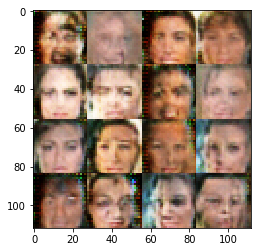

Epoch 1/1... Generator Loss: 0.8699 Discriminator Loss: 1.2959...
Epoch 1/1... Generator Loss: 0.7607 Discriminator Loss: 1.2819...
Epoch 1/1... Generator Loss: 0.9458 Discriminator Loss: 1.3747...
Epoch 1/1... Generator Loss: 0.6430 Discriminator Loss: 1.2902...
Epoch 1/1... Generator Loss: 0.7808 Discriminator Loss: 1.3626...
Epoch 1/1... Generator Loss: 1.1474 Discriminator Loss: 1.3607...
Epoch 1/1... Generator Loss: 1.1275 Discriminator Loss: 1.4218...
Epoch 1/1... Generator Loss: 0.9219 Discriminator Loss: 1.2830...
Epoch 1/1... Generator Loss: 0.9321 Discriminator Loss: 1.3150...
Epoch 1/1... Generator Loss: 0.7069 Discriminator Loss: 1.2515...


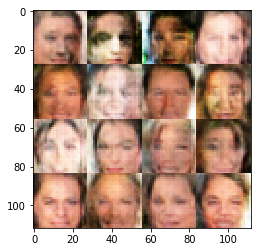

Epoch 1/1... Generator Loss: 0.8215 Discriminator Loss: 1.3974...
Epoch 1/1... Generator Loss: 0.7187 Discriminator Loss: 1.3753...
Epoch 1/1... Generator Loss: 0.6361 Discriminator Loss: 1.3144...
Epoch 1/1... Generator Loss: 0.8249 Discriminator Loss: 1.3668...
Epoch 1/1... Generator Loss: 0.8701 Discriminator Loss: 1.4132...
Epoch 1/1... Generator Loss: 1.1070 Discriminator Loss: 1.4875...
Epoch 1/1... Generator Loss: 0.8465 Discriminator Loss: 1.3315...
Epoch 1/1... Generator Loss: 0.9443 Discriminator Loss: 1.3664...
Epoch 1/1... Generator Loss: 0.9128 Discriminator Loss: 1.3344...
Epoch 1/1... Generator Loss: 0.8752 Discriminator Loss: 1.3793...


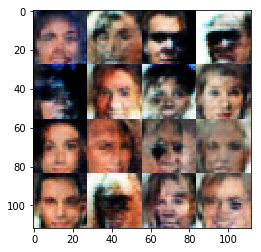

Epoch 1/1... Generator Loss: 0.6572 Discriminator Loss: 1.3414...
Epoch 1/1... Generator Loss: 0.9632 Discriminator Loss: 1.4875...
Epoch 1/1... Generator Loss: 0.5666 Discriminator Loss: 1.3879...
Epoch 1/1... Generator Loss: 0.8235 Discriminator Loss: 1.3360...
Epoch 1/1... Generator Loss: 0.6537 Discriminator Loss: 1.3761...
Epoch 1/1... Generator Loss: 0.8933 Discriminator Loss: 1.3284...
Epoch 1/1... Generator Loss: 0.8060 Discriminator Loss: 1.2968...
Epoch 1/1... Generator Loss: 0.6398 Discriminator Loss: 1.3717...
Epoch 1/1... Generator Loss: 0.9536 Discriminator Loss: 1.2588...
Epoch 1/1... Generator Loss: 0.9227 Discriminator Loss: 1.3467...


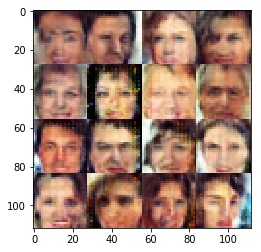

Epoch 1/1... Generator Loss: 0.6097 Discriminator Loss: 1.4592...
Epoch 1/1... Generator Loss: 0.6650 Discriminator Loss: 1.4795...
Epoch 1/1... Generator Loss: 0.8763 Discriminator Loss: 1.3401...
Epoch 1/1... Generator Loss: 0.7465 Discriminator Loss: 1.3223...
Epoch 1/1... Generator Loss: 0.8049 Discriminator Loss: 1.2509...
Epoch 1/1... Generator Loss: 0.8969 Discriminator Loss: 1.3060...
Epoch 1/1... Generator Loss: 0.8242 Discriminator Loss: 1.3482...
Epoch 1/1... Generator Loss: 0.6433 Discriminator Loss: 1.2795...
Epoch 1/1... Generator Loss: 0.8633 Discriminator Loss: 1.3795...
Epoch 1/1... Generator Loss: 0.6585 Discriminator Loss: 1.5065...


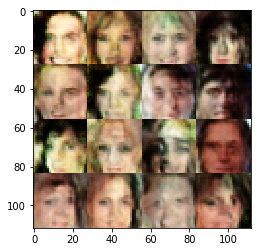

Epoch 1/1... Generator Loss: 0.8779 Discriminator Loss: 1.4289...
Epoch 1/1... Generator Loss: 0.7433 Discriminator Loss: 1.2808...
Epoch 1/1... Generator Loss: 0.7502 Discriminator Loss: 1.2238...
Epoch 1/1... Generator Loss: 0.8023 Discriminator Loss: 1.3532...
Epoch 1/1... Generator Loss: 1.1317 Discriminator Loss: 1.3263...
Epoch 1/1... Generator Loss: 0.7698 Discriminator Loss: 1.2751...
Epoch 1/1... Generator Loss: 0.7285 Discriminator Loss: 1.2878...
Epoch 1/1... Generator Loss: 0.9036 Discriminator Loss: 1.3672...
Epoch 1/1... Generator Loss: 0.7057 Discriminator Loss: 1.1809...
Epoch 1/1... Generator Loss: 0.8216 Discriminator Loss: 1.2551...


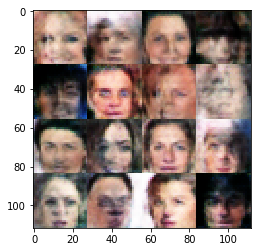

Epoch 1/1... Generator Loss: 0.8420 Discriminator Loss: 1.3611...
Epoch 1/1... Generator Loss: 0.7233 Discriminator Loss: 1.3187...
Epoch 1/1... Generator Loss: 0.9738 Discriminator Loss: 1.3465...
Epoch 1/1... Generator Loss: 0.6866 Discriminator Loss: 1.4476...
Epoch 1/1... Generator Loss: 0.8524 Discriminator Loss: 1.3227...
Epoch 1/1... Generator Loss: 0.9789 Discriminator Loss: 1.3477...
Epoch 1/1... Generator Loss: 0.6484 Discriminator Loss: 1.4072...
Epoch 1/1... Generator Loss: 0.8985 Discriminator Loss: 1.4416...
Epoch 1/1... Generator Loss: 0.6757 Discriminator Loss: 1.2267...
Epoch 1/1... Generator Loss: 0.7553 Discriminator Loss: 1.4491...


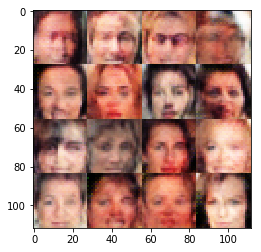

Epoch 1/1... Generator Loss: 0.7614 Discriminator Loss: 1.4147...
Epoch 1/1... Generator Loss: 0.7334 Discriminator Loss: 1.4567...
Epoch 1/1... Generator Loss: 0.7704 Discriminator Loss: 1.3304...
Epoch 1/1... Generator Loss: 0.7946 Discriminator Loss: 1.1759...
Epoch 1/1... Generator Loss: 0.8768 Discriminator Loss: 1.3634...
Epoch 1/1... Generator Loss: 0.8729 Discriminator Loss: 1.4298...
Epoch 1/1... Generator Loss: 0.6872 Discriminator Loss: 1.4746...
Epoch 1/1... Generator Loss: 0.9526 Discriminator Loss: 1.3567...
Epoch 1/1... Generator Loss: 0.7839 Discriminator Loss: 1.2553...
Epoch 1/1... Generator Loss: 1.3595 Discriminator Loss: 1.3439...


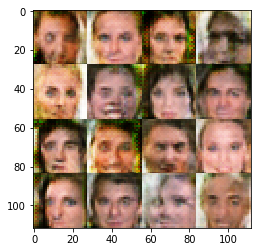

Epoch 1/1... Generator Loss: 0.8861 Discriminator Loss: 1.3312...
Epoch 1/1... Generator Loss: 0.5747 Discriminator Loss: 1.5593...
Epoch 1/1... Generator Loss: 0.7340 Discriminator Loss: 1.3701...
Epoch 1/1... Generator Loss: 0.7255 Discriminator Loss: 1.2768...
Epoch 1/1... Generator Loss: 1.0640 Discriminator Loss: 1.2839...
Epoch 1/1... Generator Loss: 0.9287 Discriminator Loss: 1.3841...
Epoch 1/1... Generator Loss: 0.8649 Discriminator Loss: 1.3748...
Epoch 1/1... Generator Loss: 0.8307 Discriminator Loss: 1.4408...
Epoch 1/1... Generator Loss: 1.0317 Discriminator Loss: 1.3523...
Epoch 1/1... Generator Loss: 0.7973 Discriminator Loss: 1.1772...


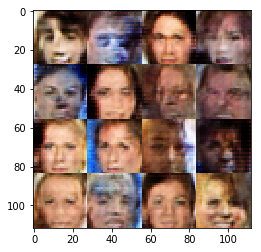

Epoch 1/1... Generator Loss: 1.0262 Discriminator Loss: 1.3051...
Epoch 1/1... Generator Loss: 0.8552 Discriminator Loss: 1.4059...
Epoch 1/1... Generator Loss: 0.5989 Discriminator Loss: 1.3448...
Epoch 1/1... Generator Loss: 0.5266 Discriminator Loss: 1.4623...
Epoch 1/1... Generator Loss: 0.9664 Discriminator Loss: 1.2655...
Epoch 1/1... Generator Loss: 0.8465 Discriminator Loss: 1.3307...
Epoch 1/1... Generator Loss: 0.7941 Discriminator Loss: 1.4850...
Epoch 1/1... Generator Loss: 0.9702 Discriminator Loss: 1.4251...
Epoch 1/1... Generator Loss: 0.7698 Discriminator Loss: 1.2935...
Epoch 1/1... Generator Loss: 0.6564 Discriminator Loss: 1.4284...


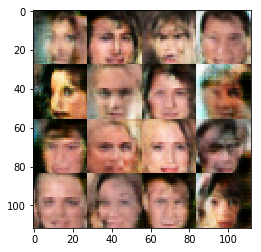

Epoch 1/1... Generator Loss: 0.4810 Discriminator Loss: 1.4890...
Epoch 1/1... Generator Loss: 0.7302 Discriminator Loss: 1.2024...
Epoch 1/1... Generator Loss: 0.7826 Discriminator Loss: 1.3943...
Epoch 1/1... Generator Loss: 0.7889 Discriminator Loss: 1.3180...
Epoch 1/1... Generator Loss: 1.0722 Discriminator Loss: 1.3876...
Epoch 1/1... Generator Loss: 1.1665 Discriminator Loss: 1.4889...
Epoch 1/1... Generator Loss: 0.8016 Discriminator Loss: 1.2744...
Epoch 1/1... Generator Loss: 0.8188 Discriminator Loss: 1.4146...
Epoch 1/1... Generator Loss: 0.8804 Discriminator Loss: 1.3928...
Epoch 1/1... Generator Loss: 0.7686 Discriminator Loss: 1.1373...


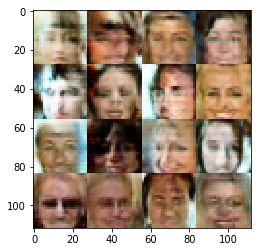

Epoch 1/1... Generator Loss: 0.7544 Discriminator Loss: 1.3319...
Epoch 1/1... Generator Loss: 0.8674 Discriminator Loss: 1.4155...
Epoch 1/1... Generator Loss: 0.9214 Discriminator Loss: 1.3220...
Epoch 1/1... Generator Loss: 0.9402 Discriminator Loss: 1.3508...
Epoch 1/1... Generator Loss: 0.7227 Discriminator Loss: 1.2138...
Epoch 1/1... Generator Loss: 0.7998 Discriminator Loss: 1.2960...
Epoch 1/1... Generator Loss: 0.7139 Discriminator Loss: 1.3158...
Epoch 1/1... Generator Loss: 0.6556 Discriminator Loss: 1.3935...
Epoch 1/1... Generator Loss: 0.9640 Discriminator Loss: 1.3752...
Epoch 1/1... Generator Loss: 0.9268 Discriminator Loss: 1.3841...


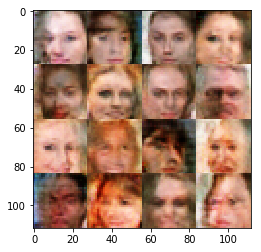

Epoch 1/1... Generator Loss: 1.0096 Discriminator Loss: 1.4228...
Epoch 1/1... Generator Loss: 1.1507 Discriminator Loss: 1.3035...
Epoch 1/1... Generator Loss: 0.7941 Discriminator Loss: 1.3116...
Epoch 1/1... Generator Loss: 0.8449 Discriminator Loss: 1.3176...
Epoch 1/1... Generator Loss: 0.9765 Discriminator Loss: 1.4274...
Epoch 1/1... Generator Loss: 0.8840 Discriminator Loss: 1.1884...
Epoch 1/1... Generator Loss: 0.9221 Discriminator Loss: 1.3601...
Epoch 1/1... Generator Loss: 0.6530 Discriminator Loss: 1.3269...
Epoch 1/1... Generator Loss: 0.7278 Discriminator Loss: 1.3060...
Epoch 1/1... Generator Loss: 0.7610 Discriminator Loss: 1.3209...


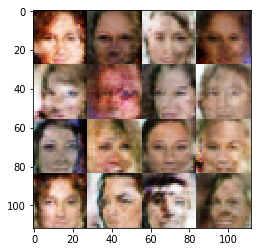

Epoch 1/1... Generator Loss: 0.7507 Discriminator Loss: 1.4076...
Epoch 1/1... Generator Loss: 0.9060 Discriminator Loss: 1.3408...
Epoch 1/1... Generator Loss: 0.8458 Discriminator Loss: 1.4230...
Epoch 1/1... Generator Loss: 0.7911 Discriminator Loss: 1.3658...
Epoch 1/1... Generator Loss: 0.9380 Discriminator Loss: 1.4248...
Epoch 1/1... Generator Loss: 0.9591 Discriminator Loss: 1.4575...
Epoch 1/1... Generator Loss: 0.7345 Discriminator Loss: 1.2750...
Epoch 1/1... Generator Loss: 0.7560 Discriminator Loss: 1.3147...
Epoch 1/1... Generator Loss: 1.0116 Discriminator Loss: 1.3594...
Epoch 1/1... Generator Loss: 0.8963 Discriminator Loss: 1.2572...


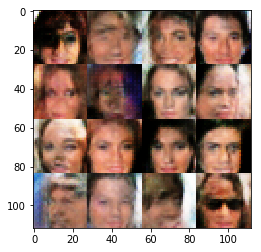

Epoch 1/1... Generator Loss: 0.7527 Discriminator Loss: 1.2549...
Epoch 1/1... Generator Loss: 0.9741 Discriminator Loss: 1.3691...
Epoch 1/1... Generator Loss: 1.0287 Discriminator Loss: 1.5546...
Epoch 1/1... Generator Loss: 1.2177 Discriminator Loss: 1.2324...
Epoch 1/1... Generator Loss: 0.9315 Discriminator Loss: 1.3783...
Epoch 1/1... Generator Loss: 0.8261 Discriminator Loss: 1.3427...
Epoch 1/1... Generator Loss: 0.6741 Discriminator Loss: 1.3345...
Epoch 1/1... Generator Loss: 0.8652 Discriminator Loss: 1.3885...
Epoch 1/1... Generator Loss: 0.8978 Discriminator Loss: 1.3579...
Epoch 1/1... Generator Loss: 0.7674 Discriminator Loss: 1.3969...


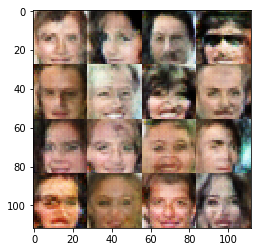

Epoch 1/1... Generator Loss: 0.6552 Discriminator Loss: 1.3856...
Epoch 1/1... Generator Loss: 0.8382 Discriminator Loss: 1.3160...
Epoch 1/1... Generator Loss: 0.8534 Discriminator Loss: 1.4271...
Epoch 1/1... Generator Loss: 0.6867 Discriminator Loss: 1.3225...
Epoch 1/1... Generator Loss: 0.7847 Discriminator Loss: 1.4859...
Epoch 1/1... Generator Loss: 1.0310 Discriminator Loss: 1.2183...


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.